<a href="https://colab.research.google.com/github/maz-joko78/VTCI-LANDSAT-LC08-C02-T1_L2/blob/main/1VTCI_2015.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from IPython import get_ipython
from IPython.display import display
# %%
# Install necessary libraries
!pip install numpy rasterio matplotlib scikit-learn geopandas
# %%
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os
import sys
from google.colab import drive
import geopandas as gpd # Import geopandas

# Mount Google Drive
# Pastikan Anda sudah mengizinkan Google Colab mengakses Google Drive Anda saat menjalankan sel ini.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# %%
# =============================
# 1. Load LST dan NDVI
# =============================
# VERIFIKASI PATH FILE ANDA DI SINI SETELAH MOUNT GOOGLE DRIVE
# Contoh:
lst_path = '/content/drive/MyDrive/Data_2015/LST2015.tif'
ndvi_path = '/content/drive/MyDrive/Data_2015/NDVI2015.tif'

try:
    # Buka file LST
    with rasterio.open(lst_path) as src:
        lst = src.read(1) # Baca band pertama (band 1)
        lst_meta = src.meta # Simpan metadata
        lst_nodata = src.nodata # Ambil nilai nodata LST

        # Hitung extent spasial dari metadata raster
        # rasterio bounds memberikan (left, bottom, right, top) yaitu (xmin, ymin, xmax, ymax)
        # imshow matplotlib mengharapkan (xmin, xmax, ymin, ymax)
        # Koreksi urutan untuk imshow
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

    # Buka file NDVI
    with rasterio.open(ndvi_path) as src:
        ndvi = src.read(1) # Baca band pertama (band 1)
        ndvi_nodata = src.nodata # Ambil nilai nodata NDVI


    # Hitung nilai min/max LST dan NDVI dari data yang *valid* (bukan NaN/nodata dan LST >= 0)
    temp_mask_lst = ~np.isnan(lst) # Masking untuk NaN
    if lst_nodata is not None: # Jika ada nilai nodata eksplisit
         temp_mask_lst = temp_mask_lst & (lst != lst_nodata) # Tambahkan nodata ke mask
    temp_mask_lst = temp_mask_lst & (lst >= 0) # Tambahkan kondisi LST >= 0

    lst_max_value = np.nanmax(lst[temp_mask_lst]) if np.any(temp_mask_lst) else np.nan
    lst_min_value = np.nanmin(lst[temp_mask_lst]) if np.any(temp_mask_lst) else np.nan

    temp_mask_ndvi = ~np.isnan(ndvi) # Masking untuk NaN
    if ndvi_nodata is not None: # Jika ada nilai nodata eksplisit
         temp_mask_ndvi = temp_mask_ndvi & (ndvi != ndvi_nodata) # Tambahkan nodata ke mask

    ndvi_max_value = np.nanmax(ndvi[temp_mask_ndvi]) if np.any(temp_mask_ndvi) else np.nan
    ndvi_min_value = np.nanmin(ndvi[temp_mask_ndvi]) if np.any(temp_mask_ndvi) else np.nan


    print(f"Nilai maksimum LST: {lst_max_value:.2f}")
    print(f"Nilai minimum LST: {lst_min_value:.2f}")

    print(f"Nilai maksimum NDVI: {ndvi_max_value:.2f}")
    print(f"Nilai minimum NDVI: {ndvi_min_value:.2f}")

except rasterio.errors.RasterioIOError as e:
    print(f"Error membuka file raster: {e}")
    print("Pastikan path file benar dan file ada di Google Drive Anda.")
    # Hentikan eksekusi jika file tidak dapat dibuka
    sys.exit("Gagal memuat data raster.") # Menggunakan sys.exit untuk menghentikan seluruh script

# %%
# =============================
# 2. Mask NaN atau nilai no-data DAN nilai negatif LST
# =============================
# Buat mask gabungan untuk mengecualikan:
# - Nilai NaN
# - Nilai no-data eksplisit
# - Nilai LST yang negatif (karena LST dalam Kelvin/Celcius biasanya tidak negatif untuk permukaan bumi)

mask = ~np.isnan(lst) # Masking NaN di LST
if lst_nodata is not None: # Jika ada nodata di LST
    mask = mask & (lst != lst_nodata) # Tambahkan nodata LST ke mask
mask = mask & (lst >= 0) # Hanya ambil LST yang non-negatif

mask = mask & ~np.isnan(ndvi) # Masking NaN di NDVI
if ndvi_nodata is not None: # Jika ada nodata di NDVI
    mask = mask & (ndvi != ndvi_nodata) # Tambahkan nodata NDVI ke mask
# Opsi: Anda bisa menambahkan mask untuk rentang NDVI di sini juga,
# tetapi kita akan melakukan itu di langkah binning untuk kemudahan.
# mask = mask & (ndvi >= -1) & (ndvi <= 1)


# Terapkan mask untuk "meratakan" array, hanya mengambil nilai yang valid
lst = lst[mask]
ndvi = ndvi[mask]

# Pastikan masih ada data yang tersisa setelah masking
if len(lst) == 0:
    print("Tidak ada data yang valid tersisa setelah masking (NaN, nodata, LST negatif).")
    sys.exit("Tidak ada data valid untuk diproses.")

Nilai maksimum LST: 79.27
Nilai minimum LST: 1.34
Nilai maksimum NDVI: 1.00
Nilai minimum NDVI: -1.00


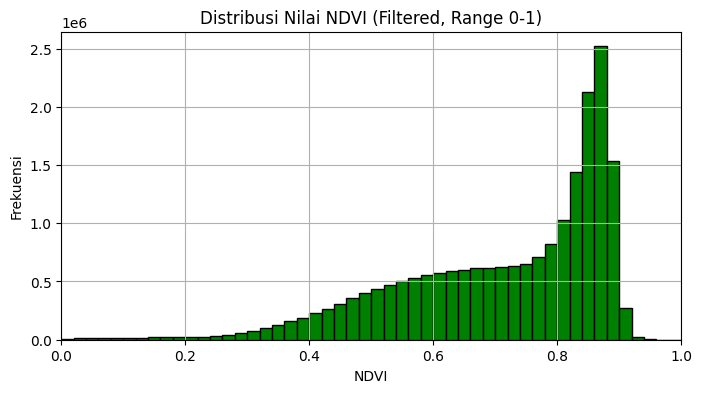

Persamaan Warm edge (LSTmax): LST = -18.8161 * NDVI + 54.4809
Persamaan Cold edge (LSTmin): LST = 0.4024 * NDVI + 31.3151


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


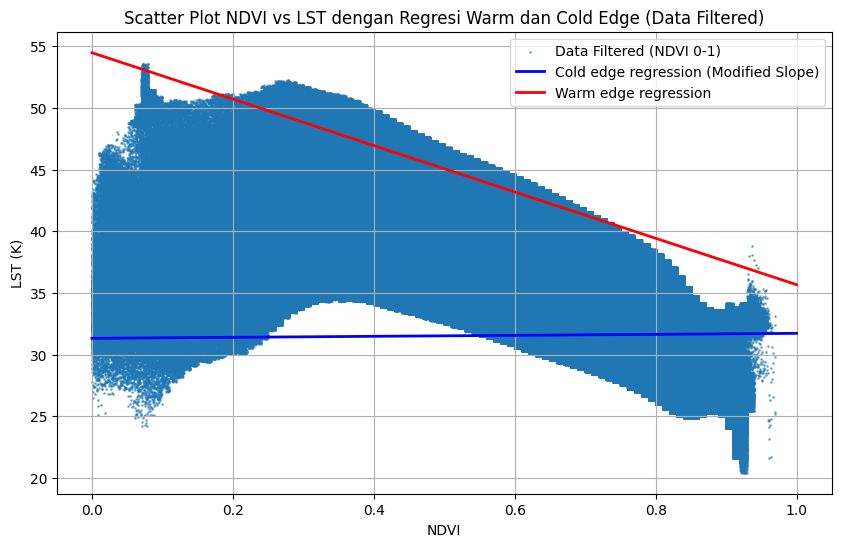

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


Rentang NDVI untuk visualisasi (2%-98%): 0.32 - 0.90


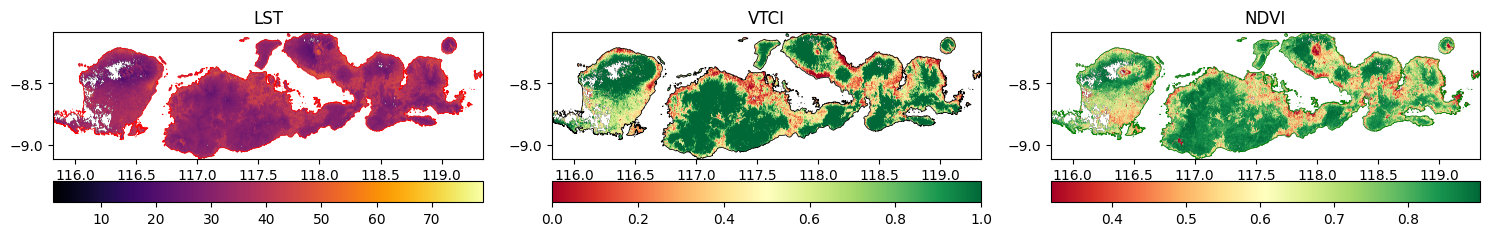

Mengekspor raster VTCI ke: /content/drive/MyDrive/Tahunan_VTCI2015_output/VTCI_output.tif
Ekspor raster VTCI berhasil.
Mengekspor grafik peta ke: /content/drive/MyDrive/Tahunan_VTCI2015_output/VTCI_NDVI_LST_Maps.png
Ekspor grafik peta berhasil.
Mengekspor grafik scatter plot ke: /content/drive/MyDrive/Tahunan_VTCI2015_output/NDVI_LST_ScatterPlot.png


<ipython-input-4-b573d5e4b54f>:447: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig_scatter.savefig(output_scatter_plot_path, dpi=300, bbox_inches='tight') # Simpan scatter plot


In [ ]:
# %%
# =============================
# 3. Binning NDVI dan filter outlier LST
# =============================
# Tentukan tepi bin hanya untuk rentang NDVI 0 hingga 1
bin_edges = np.arange(0, 1.01, 0.01) # Membuat bin dari 0 hingga 1 dengan lebar 0.01. Termasuk 1.00.

# Pusat bin dihitung dari tepi bin
# Seharusnya menggunakan ndvi_bins[:-1] dan ndvi_bins[1:]
# Perbaikan: Gunakan bin_edges
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

lst_filtered = []
ndvi_filtered = []

# Buat mask awal untuk hanya memilih data dengan nilai NDVI antara 0 dan 1 (eksklusif 1)
# Ini penting karena bin_edges terakhir adalah 1.01, bin terakhir (1.00 - 1.01)
# akan mencakup nilai tepat 1.0.
initial_ndvi_range_mask_for_binning = np.logical_and(ndvi >= 0, ndvi < 1)

# Terapkan mask rentang NDVI [0, 1) pada data yang sudah dimasking sebelumnya
ndvi_for_binning = ndvi[initial_ndvi_range_mask_for_binning]
lst_for_binning = lst[initial_ndvi_range_mask_for_binning]

# Pastikan masih ada data di rentang NDVI [0, 1) untuk binning
if len(lst_for_binning) == 0:
     print("Tidak ada data yang valid tersisa dalam rentang NDVI [0, 1) setelah masking.")
     sys.exit("Tidak cukup data valid untuk binning dan regresi.")


# Lakukan binning dan filtering outlier pada data yang sudah difilter rentang NDVI [0, 1)
for i in range(len(bin_edges) - 1): # Iterasi sejumlah bin (tepi-1)
    # Tentukan mask untuk data yang termasuk dalam bin saat ini [bin_edges[i], bin_edges[i+1])
    # Gunakan data yang sudah difilter rentang NDVI [0, 1)
    bin_mask = np.logical_and(ndvi_for_binning >= bin_edges[i], ndvi_for_binning < bin_edges[i+1])

    # Ambil data LST dan NDVI untuk bin ini menggunakan mask bin
    lst_bin = lst_for_binning[bin_mask]
    ndvi_bin = ndvi_for_binning[bin_mask]

    # Filter outlier LST dalam bin ini jika jumlah data mencukupi
    if len(lst_bin) > 20: # Minimum 20 data point dalam bin untuk filtering
        median = np.median(lst_bin)
        std = np.std(lst_bin)
        # Gunakan filter outlier 2.0 std deviasi dari median
        lower = median - 2.0 * std
        upper = median + 2.0 * std
        inlier_mask = np.logical_and(lst_bin >= lower, lst_bin <= upper)

        # Tambahkan data inlier ke list hasil filter
        lst_filtered.append(lst_bin[inlier_mask])
        ndvi_filtered.append(ndvi_bin[inlier_mask])

# Check if lst_filtered is empty before concatenating
if not lst_filtered:
    print("Tidak ada data valid ditemukan setelah filtering outlier per bin.")
    sys.exit("Tidak cukup data valid untuk regresi setelah filtering outlier.")
else:
    # Gabungkan data yang sudah difilter menjadi satu array
    lst_filtered = np.concatenate(lst_filtered)
    ndvi_filtered = np.concatenate(ndvi_filtered)

# Optional: Plot histogram of filtered NDVI data to check distribution
# Pastikan ndvi_filtered di sini hanya berisi nilai dalam rentang [0, 1) jika proses berjalan lancar
fig_hist, ax_hist = plt.subplots(figsize=(8, 4))
# Tentukan bins untuk histogram sesuai rentang [0, 1]
ax_hist.hist(ndvi_filtered, bins=np.arange(0, 1.01, 0.02), color='green', edgecolor='black') # Bins lebih lebar untuk visualisasi
ax_hist.set_title('Distribusi Nilai NDVI (Filtered, Range 0-1)')
ax_hist.set_xlabel('NDVI')
ax_hist.set_ylabel('Frekuensi')
ax_hist.set_xlim(0, 1) # Batasi sumbu x antara 0 dan 1
ax_hist.grid(True)
plt.show()

# %%
# =============================
# 4. Regressi Warm dan Cold Edge
# =============================
max_lst_per_bin = []
min_lst_per_bin = []
valid_bin_centers = [] # Menyimpan pusat bin yang memiliki data setelah filtering

# Gunakan data yang sudah difilter outlier (ndvi_filtered, lst_filtered) untuk mencari max/min LST per bin
for i in range(len(bin_edges) - 1): # Iterasi sejumlah bin (tepi-1)
    # Tentukan mask untuk data yang termasuk dalam bin saat ini [bin_edges[i], bin_edges[i+1])
    bin_mask = np.logical_and(ndvi_filtered >= bin_edges[i], ndvi_filtered < bin_edges[i+1])
    lst_bin = lst_filtered[bin_mask]

    # Jika bin ini memiliki data setelah filtering outlier
    if len(lst_bin) > 0:
        max_lst_per_bin.append(np.max(lst_bin)) # Ambil nilai LST maksimum dalam bin ini
        min_lst_per_bin.append(np.min(lst_bin)) # Ambil nilai LST minimum dalam bin ini
        # Tambahkan pusat bin yang sesuai
        valid_bin_centers.append(bin_centers[i])

# Check if valid_bin_centers is empty before proceeding
if not valid_bin_centers:
    print("Tidak ada bin yang memiliki data valid setelah filtering outlier. Tidak dapat melakukan regresi.")
    sys.exit("Tidak cukup data valid untuk regresi.")

# Reshape pusat bin yang valid untuk scikit-learn (array 2D dengan 1 kolom)
# Perbaikan: Menggunakan -1 pada reshape
valid_bin_centers_reshaped = np.array(valid_bin_centers).reshape(-1, 1)

# Check if there are enough samples for linear regression (minimal 2 titik)
if len(valid_bin_centers_reshaped) < 2:
    print("Tidak cukup titik data (bin valid) untuk melakukan regresi linier. Butuh minimal 2.")
    sys.exit("Tidak cukup data untuk regresi linier.")

# Lakukan regresi linier untuk warm edge (LST maksimum) dan cold edge (LST minimum)
warm_model = LinearRegression().fit(valid_bin_centers_reshaped, max_lst_per_bin)
cold_model = LinearRegression().fit(valid_bin_centers_reshaped, min_lst_per_bin)

# Ambil koefisien (slope) dan intercept dari model regresi
warm_a, warm_b = warm_model.coef_[0], warm_model.intercept_
cold_a, cold_b = cold_model.coef_[0], cold_model.intercept_

# Tambahkan perintah jika nilai slope cold negatif ubah menjadi absolut positif
if cold_a < 0:
    #print(f"Slope cold edge negatif ({cold_a:.4f}). Mengubahnya menjadi nilai absolut.")
    cold_a = 0.1*abs(cold_a)

print(f"Persamaan Warm edge (LSTmax): LST = {warm_a:.4f} * NDVI + {warm_b:.4f}")
print(f"Persamaan Cold edge (LSTmin): LST = {cold_a:.4f} * NDVI + {cold_b:.4f}")


# %%
# ============================================
# 5. Scatter Plot NDVI vs LST + Linear Regression Warm & Cold Edge
# ============================================

# Gunakan data NDVI dan LST yang sudah difilter (termasuk rentang [0, 1))
# Masking untuk scatter plot dilakukan di sini untuk data yang sudah difilter
# Filter lagi untuk memastikan hanya plot data di rentang NDVI [0, 1] (inclusive 1)
ndvi_plot_mask = np.logical_and(ndvi_filtered >= 0, ndvi_filtered <= 1)

ndvi_for_plot = ndvi_filtered[ndvi_plot_mask]
lst_for_plot = lst_filtered[ndvi_plot_mask]


# Plot data scatter
fig_scatter, ax_scatter = plt.subplots(figsize=(10, 6))
# Gunakan data yang sudah difilter dan di-mask rentang [0, 1] untuk scatter plot
ax_scatter.scatter(ndvi_for_plot, lst_for_plot, s=1, alpha=0.5, label='Data Filtered (NDVI 0-1)')

# Plot garis regresi warm dan cold edge menggunakan koefisien dari Langkah 4
# Gunakan rentang NDVI yang sesuai dengan data yang di-plot (0-1) untuk membuat garis
# Membuat nilai NDVI untuk plotting garis
ndvi_range_for_line_plot = np.linspace(0, 1, 100) # 100 titik antara 0 dan 1

# Hitung nilai LST yang diprediksi oleh model regresi untuk garis
# Gunakan koefisien warm_a dan warm_b yang didapat dari model warm asli
warm_line_plot = warm_a * ndvi_range_for_line_plot + warm_b

# Hitung nilai LST yang diprediksi untuk garis cold edge
# GUNAKAN cold_a dan cold_b yang mungkin sudah dimodifikasi (abs(cold_a))
# Jangan gunakan cold_model.predict() lagi
cold_line_plot = cold_a * ndvi_range_for_line_plot + cold_b


# Plot garis regresi
ax_scatter.plot(ndvi_range_for_line_plot, cold_line_plot, color='blue', label='Cold edge regression (Modified Slope)', linewidth=2) # Ubah label untuk klarifikasi
ax_scatter.plot(ndvi_range_for_line_plot, warm_line_plot, color='red', label='Warm edge regression', linewidth=2)


ax_scatter.set_xlabel("NDVI")
ax_scatter.set_ylabel("LST (K)")
ax_scatter.set_title("Scatter Plot NDVI vs LST dengan Regresi Warm dan Cold Edge (Data Filtered)")
ax_scatter.legend()
ax_scatter.grid(True)
plt.show()

# %%
# =============================
# 5. Hitung VTCI
# =============================
# Reload the full rasters for VTCI calculation
# Read with masked=True to automatically convert nodata to NaN by rasterio
try:
    with rasterio.open(lst_path) as src:
        lst_full_calc = src.read(1, masked=True) # Read with rasterio masking nodata to NaN
        # Simpan metadata asli untuk menyimpan hasil
        output_meta = src.meta.copy()
        # Perbarui dtype ke float32 untuk VTCI (nilai pecahan)
        output_meta.update(dtype='float32', count=1)

    with rasterio.open(ndvi_path) as src:
        ndvi_full_calc = src.read(1, masked=True) # Read with rasterio masking nodata to NaN

except rasterio.errors.RasterioIOError as e:
    print(f"Error membuka kembali file raster untuk perhitungan VTCI: {e}")
    sys.exit("Gagal memuat data raster untuk perhitungan VTCI.")


# Terapkan mask tambahan untuk LST < 0 langsung pada data kalkulasi
# NaNs yang dibuat oleh masked=True akan tetap NaN
lst_full_calc_masked = np.ma.masked_where(lst_full_calc < 0, lst_full_calc)
# Sebarkan mask dari LST ke data NDVI untuk perhitungan yang konsisten
ndvi_full_calc_masked = np.ma.masked_where(np.ma.getmask(lst_full_calc_masked), ndvi_full_calc)

# Terapkan mask tambahan untuk NDVI di luar rentang [0, 1] pada data kalkulasi
# Karena regresi warm/cold edge hanya valid untuk NDVI 0-1
ndvi_full_calc_masked = np.ma.masked_where(np.ma.getmask(ndvi_full_calc_masked) | (ndvi_full_calc_masked < 0) | (ndvi_full_calc_masked > 1), ndvi_full_calc_masked)
# Sebarkan mask NDVI yang baru ke data LST
lst_full_calc_masked = np.ma.masked_where(np.ma.getmask(ndvi_full_calc_masked), lst_full_calc_masked)


# Hitung LSTmax dan LSTmin untuk seluruh raster berdasarkan koefisien regresi
# Hasil ini akan mengandung NaNs di mana data asli masked atau LST negatif atau NDVI di luar 0-1
lst_max_calc = warm_a * ndvi_full_calc_masked + warm_b
lst_min_calc = cold_a * ndvi_full_calc_masked + cold_b


# Buat mask gabungan untuk lokasi data yang valid untuk perhitungan VTCI
# Exclude area di mana lst_max == lst_min atau di mana data asli NaN atau LST negatif atau NDVI di luar 0-1
# Gunakan mask dari masked arrays yang sudah dibuat
valid_vtci_mask = ~np.ma.getmask(lst_full_calc_masked) & ~np.ma.getmask(ndvi_full_calc_masked)
# Tambahkan kondisi untuk menghindari pembagian dengan nol jika LSTmax dan LSTmin sangat dekat
valid_vtci_mask = valid_vtci_mask & ~np.isclose(lst_max_calc, lst_min_calc, rtol=1e-5, atol=1e-8, equal_nan=True)


# Inisialisasi array VTCI dengan NaNs dengan ukuran yang sama seperti raster input
vtci_full = np.full(lst_full_calc.shape, np.nan)

# Hitung VTCI hanya untuk lokasi yang valid
# Akses hanya lokasi yang valid di semua array menggunakan mask
numerator_valid = lst_max_calc[valid_vtci_mask] - lst_full_calc_masked[valid_vtci_mask]
denominator_valid = lst_max_calc[valid_vtci_mask] - lst_min_calc[valid_vtci_mask]

# Lakukan pembagian
vtci_valid = numerator_valid / denominator_valid

# Clip nilai VTCI ke rentang [0, 1]
vtci_valid_clipped = np.clip(vtci_valid, 0, 1)

# Tempatkan nilai VTCI yang dihitung kembali ke array penuh
# Gunakan mask yang sama yang digunakan untuk menghitung vtci_valid_clipped
# Perbaikan: Jangan filter NaNs lagi di sini, karena vtci_valid_clipped sudah sesuai dengan mask
vtci_full[valid_vtci_mask] = vtci_valid_clipped


# Atur nodata value untuk output raster VTCI
# Gunakan nilai yang berbeda dari rentang VTCI [0, 1], misalnya -9999
output_nodata = -9999
# Ganti NaN (termasuk dari pembagian nol atau area masked awal) dengan nodata value
vtci_full[np.isnan(vtci_full)] = output_nodata
output_meta.update(nodata=output_nodata)

# %%
# =============================
# 6. Visualisasi dengan Masking, Koordinat Spasial, dan AOI
# =============================

# --- Add AOI File Path ---
# **PENTING:** Ganti path ini dengan path file AOI Anda (misalnya, shapefile, GeoJSON) di Google Drive.
aoi_path = '/content/drive/MyDrive/Data_2022/NTB.shp' # <-- Ganti dengan path file AOI Anda

# 1. Buat mask berdasarkan data yang valid (non-NaN/nodata DAN LST non-negatif DAN NDVI 0-1) dan baca metadata untuk visualisasi
try:
    # Baca kembali raster LST dengan masked=True untuk visualisasi
    with rasterio.open(lst_path) as src:
        lst_full_viz = src.read(1, masked=True)
        # Pastikan extent spasial tersedia (sudah dihitung di Langkah 1 jika berhasil)
        if 'extent' not in locals():
             extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]


    # Baca kembali raster NDVI dengan masked=True untuk visualisasi
    with rasterio.open(ndvi_path) as src:
        ndvi_full_viz = src.read(1, masked=True, boundless=True, fill_value=np.nan)

    # Load file AOI (Area of Interest)
    aoi_gdf = None # Inisialisasi AOI_gdf ke None
    try:
        aoi_gdf = gpd.read_file(aoi_path)
        # Optional: Reprojeksi AOI ke CRS raster jika tidak cocok
        with rasterio.open(lst_path) as src_crs: # Buka sementara LST lagi untuk mendapatkan CRS-nya
             raster_crs = src_crs.crs

        if aoi_gdf.crs != raster_crs:
            print(f"Reprojeksi AOI dari {aoi_gdf.crs} ke {raster_crs}")
            aoi_gdf = aoi_gdf.to_crs(raster_crs)
        # print(f"AOI loaded with CRS: {aoi_gdf.crs}") # Uncomment to print AOI CRS

    except Exception as e:
        print(f"Error memuat file AOI: {e}")
        print(f"Pastikan path AOI '{aoi_path}' benar dan file ada.")
        # aoi_gdf tetap None jika loading gagal

    # Gunakan mask gabungan dari NaN, LST negatif, dan NDVI di luar 0-1 untuk visualisasi
    # Kita akan menggunakan masked arrays untuk visualisasi matplotlib agar piksel masked tidak ditampilkan
    # Mask ini harus mencerminkan data yang dianggap 'valid' untuk diinterpretasikan secara visual.
    mask_viz = ~np.isnan(lst_full_viz) & (lst_full_viz >= 0)
    mask_viz = mask_viz & ~np.isnan(ndvi_full_viz)
    mask_viz = mask_viz & (ndvi_full_viz >= 0) & (ndvi_full_viz <= 1) # Tambahkan mask NDVI 0-1 untuk visualisasi


    # Ambil nilai NDVI yang valid (sesuai mask_viz) untuk menentukan vmin/vmax plot NDVI
    valid_ndvi_viz = ndvi_full_viz[mask_viz]
    # Hitung persentil untuk rentang vmin/vmax plot NDVI yang lebih sesuai
    if len(valid_ndvi_viz) > 0:
        # Hitung persentil ke-2 dan ke-98 untuk rentang vmin/vmax yang robust
        ndvi_vmin_viz = np.percentile(valid_ndvi_viz, 2)
        ndvi_vmax_viz = np.percentile(valid_ndvi_viz, 98)
        # Pastikan rentang berada dalam batas teoritis NDVI [-1, 1]
        ndvi_vmin_viz = max(ndvi_vmin_viz, 0.0)
        ndvi_vmax_viz = min(ndvi_vmax_viz, 1.0)
        print(f"Rentang NDVI untuk visualisasi (2%-98%): {ndvi_vmin_viz:.2f} - {ndvi_vmax_viz:.2f}")
    else:
        # Fallback ke rentang teoritis jika tidak ada data valid ditemukan
        ndvi_vmin_viz = -1.0
        ndvi_vmax_viz = 1.0
        print("Tidak ada data NDVI valid ditemukan untuk menentukan rentang visualisasi. Menggunakan rentang default [-1, 1].")


except rasterio.errors.RasterioIOError as e:
    print(f"Error membuka kembali file raster untuk visualisasi: {e}")
    print("Tidak dapat membuat peta tanpa data raster.")
    sys.exit("Gagal memuat data raster untuk visualisasi.")


# Simpan referensi figure dan axes untuk visualisasi peta
fig_maps, axes_maps = plt.subplots(1, 3, figsize=(15, 6))

# --- Plot 1: LST ---
plt.subplot(1, 3, 1)
# Gunakan masked array untuk menerapkan mask visualisasi (exclude NaN, nodata, LST neg, NDVI non 0-1)
# Namun, untuk plot LST, kita mungkin hanya ingin mengecualikan NaN, nodata, LST neg.
# Mari kita buat mask_viz_lst hanya untuk LST yang relevan untuk visualisasi LST
mask_viz_lst = ~np.isnan(lst_full_viz) & (lst_full_viz >= 0)
if lst_nodata is not None:
     mask_viz_lst = mask_viz_lst & (lst_full_viz != lst_nodata)

masked_lst = np.ma.masked_array(lst_full_viz, ~mask_viz_lst)  # Mask data tidak valid
# Tambahkan parameter extent ke imshow
im1 = plt.imshow(masked_lst, cmap='inferno', extent=extent)
plt.title('LST')
# Gunakan orientasi horizontal dan sesuaikan posisi colorbar
plt.colorbar(im1, orientation='horizontal', fraction=0.046, pad=0.04)
# Plot batas AOI jika berhasil dimuat
if aoi_gdf is not None:
    aoi_gdf.plot(ax=axes_maps[0], facecolor='none', edgecolor='red', linewidth=0.5) # Plot outline AOI
    # Optional: Zoom ke extent AOI (uncomment jika ingin)
    # try:
    #     minx, miny, maxx, maxy = aoi_gdf.total_bounds
    #     axes_maps[0].set_xlim(minx, maxx)
    #     # matplotlib 'ylim' adalah [bottom, top], rasterio/imshow 'extent' adalah [left, right, bottom, top]
    #     axes_maps[0].set_ylim(miny, maxy)
    # except Exception as e:
    #     print(f"Error zoom ke extent AOI pada plot LST: {e}")


# --- Plot 2: VTCI ---
plt.subplot(1, 3, 2)
# Gunakan array vtci_full yang sudah dihitung dan terapkan mask visualisasi (exclude nodata -9999 dan area yg di-mask_viz)
# Buat masked array dari vtci_full, pastikan nodata value -9999 juga dianggap masked
masked_vtci_viz = np.ma.masked_where(vtci_full == output_nodata, vtci_full)
# Terapkan mask visualisasi tambahan (exclude NaN, nodata, LST neg, NDVI non 0-1) agar konsisten
masked_vtci_viz = np.ma.masked_array(masked_vtci_viz, ~mask_viz)

# Tambahkan parameter extent ke imshow dan rentang VTCI [0, 1]
im2 = plt.imshow(masked_vtci_viz, cmap='RdYlGn', extent=extent, vmin=0, vmax=1) # Rentang VTCI adalah 0-1
plt.title('VTCI')
# Gunakan orientasi horizontal dan sesuaikan posisi colorbar
plt.colorbar(im2, orientation='horizontal', fraction=0.046, pad=0.04)
# Plot batas AOI jika berhasil dimuat
if aoi_gdf is not None:
    aoi_gdf.plot(ax=axes_maps[1], facecolor='none', edgecolor='black', linewidth=0.5) # Plot outline AOI
    # Optional: Zoom ke extent AOI (uncomment jika ingin)
    # try:
    #     minx, miny, maxx, maxy = aoi_gdf.total_bounds
    #     axes_maps[1].set_xlim(minx, maxx)
    #     axes_maps[1].set_ylim(miny, maxy) # Note: rasterio/imshow 'extent' is [left, right, bottom, top], matplotlib 'ylim' is [bottom, top]
    # except Exception as e:
    #     print(f"Error zoom ke extent AOI pada plot VTCI: {e}")


# --- Plot 3: NDVI ---
plt.subplot(1, 3, 3)
# Gunakan masked array untuk menerapkan mask visualisasi (exclude NaN, nodata, LST neg, NDVI non 0-1)
masked_ndvi = np.ma.masked_array(ndvi_full_viz, ~mask_viz)  # Mask data tidak valid
# Tambahkan parameter extent ke imshow dan tentukan vmin/vmax berdasarkan persentil dari data valid 0-1
im3 = plt.imshow(masked_ndvi, cmap='RdYlGn', extent=extent, vmin=ndvi_vmin_viz, vmax=ndvi_vmax_viz) # Set rentang NDVI berdasarkan persentil dari data valid 0-1
plt.title('NDVI')
# Gunakan orientasi horizontal dan sesuaikan posisi colorbar
plt.colorbar(im3, orientation='horizontal', fraction=0.046, pad=0.04)
# Plot batas AOI jika berhasil dimuat
if aoi_gdf is not None:
    aoi_gdf.plot(ax=axes_maps[2], facecolor='none', edgecolor='green', linewidth=0.5) # Plot outline AOI
    # Optional: Zoom ke extent AOI (uncomment jika ingin)
    # try:
    #     minx, miny, maxx, maxy = aoi_gdf.total_bounds
    #     axes_maps[2].set_xlim(minx, maxx)
    #     axes_maps[2].set_ylim(miny, maxy) # Note: rasterio/imshow 'extent' is [left, right, bottom, top], matplotlib 'ylim' is [bottom, top]
    # except Exception as e:
    #     print(f"Error zoom ke extent AOI pada plot NDVI: {e}")


plt.tight_layout() # Sesuaikan layout agar tidak tumpang tindih
plt.show()

# %%
# =============================
# 8. Ekspor Hasil ke Google Drive
# =============================

# GANTI FOLDER TARGET DI GOOGLE DRIVE ANDA DI SINI
output_dir = '/content/drive/MyDrive/Tahunan_VTCI2015_output/' # Ganti dengan folder target

# Buat folder jika belum ada
os.makedirs(output_dir, exist_ok=True)

# Nama file output
output_vtci_raster_path = os.path.join(output_dir, 'VTCI_output.tif')
output_maps_plot_path = os.path.join(output_dir, 'VTCI_NDVI_LST_Maps.png')
output_scatter_plot_path = os.path.join(output_dir, 'NDVI_LST_ScatterPlot.png')
output_histogram_plot_path = os.path.join(output_dir, 'NDVI_Filtered_Histogram.png')
output_regression_coeffs_path = os.path.join(output_dir, 'regression_coefficients.txt')
output_filtered_data_path = os.path.join(output_dir, 'filtered_data.csv')


# 8.1 Ekspor Raster VTCI ke GeoTIFF
print(f"Mengekspor raster VTCI ke: {output_vtci_raster_path}")
try:
    with rasterio.open(output_vtci_raster_path, 'w', **output_meta) as dst:
        # Pastikan data VTCI ditulis dengan dtype float32 seperti di output_meta
        dst.write(vtci_full.astype(output_meta['dtype']), 1)
    print("Ekspor raster VTCI berhasil.")
except Exception as e:
    print(f"Gagal mengekspor raster VTCI: {e}")


# 8.2 Ekspor Grafik ke File Gambar
print(f"Mengekspor grafik peta ke: {output_maps_plot_path}")
try:
    if 'fig_maps' in locals() and fig_maps is not None:
        fig_maps.savefig(output_maps_plot_path, dpi=300, bbox_inches='tight') # Simpan plot peta
        print("Ekspor grafik peta berhasil.")
    else:
        print("Figure peta (fig_maps) tidak ditemukan atau None, tidak dapat mengekspor.")
except Exception as e:
     print(f"Gagal mengekspor grafik peta: {e}")

print(f"Mengekspor grafik scatter plot ke: {output_scatter_plot_path}")
try:
    if 'fig_scatter' in locals() and fig_scatter is not None:
        fig_scatter.savefig(output_scatter_plot_path, dpi=300, bbox_inches='tight') # Simpan scatter plot
        print("Ekspor grafik scatter plot berhasil.")
    else:
         print("Figure scatter plot (fig_scatter) tidak ditemukan atau None, tidak dapat mengekspor.")
except Exception as e:
     print(f"Gagal mengekspor grafik scatter plot: {e}")

# Simpan grafik histogram